In [41]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
import math

## Model 1

In [42]:
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2021, 1, 1)

data = pdr.get_data_yahoo('^DJI', start, end)
data = data.reset_index()
data = data.dropna()
#data1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [43]:
train_data = data[data['Date']<"2018-01-01"]
test_data = data[data['Date']>="2018-01-01"]

In [44]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [45]:
window_size = 10

x_train, y_train=[], []
for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [46]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [47]:
%%capture

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
history = model.fit(x_train, y_train, epochs=10, batch_size=30,callbacks=[es])

In [48]:
inputs=data['Close'][len(data['Close'])-len(test_data)-window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [49]:
x_test=[]

for x in range(window_size, len(inputs)):
    x_test.append(inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

24/24 [==============================] - 30s 19ms/step


In [50]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

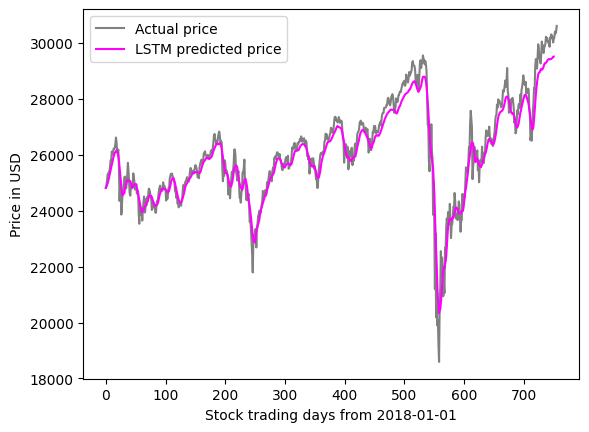

In [51]:
plt.plot(test_data.reset_index()['Close'], color = 'grey', label = 'Actual price')
plt.plot(predicted_prices, color = 'magenta', label = 'LSTM predicted price')

plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

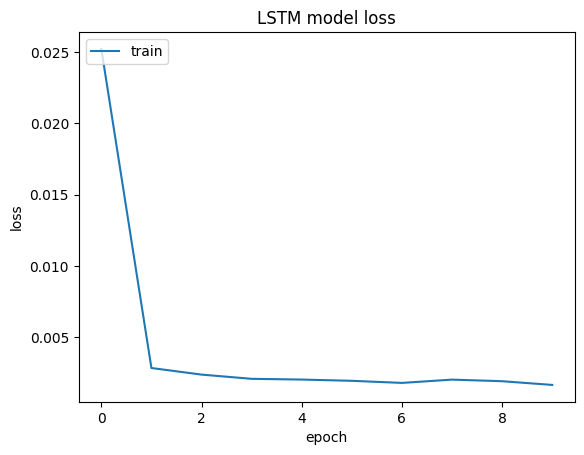

In [52]:
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
math.sqrt(metrics.mean_squared_error(test_data['Close'].values[5:],predicted_prices))

837.2384571978761

In [54]:
metrics.mean_absolute_error(test_data['Close'].values[5:],predicted_prices)

603.9511562708055

## Model 2

In [19]:
data2 = test_data.copy()

In [20]:
data2['SMA'] = data2['Close'].rolling(window_size).mean()

In [21]:
data2 = data2.reset_index()

In [25]:
df = pd.DataFrame({'act1':test_data['Close'].values.ravel(), 'pred1':predicted_prices1.ravel()})

In [26]:
data2 = pd.merge(data2, df, left_on ='Close', right_on ='act1',how='left')

<function matplotlib.pyplot.show(close=None, block=None)>

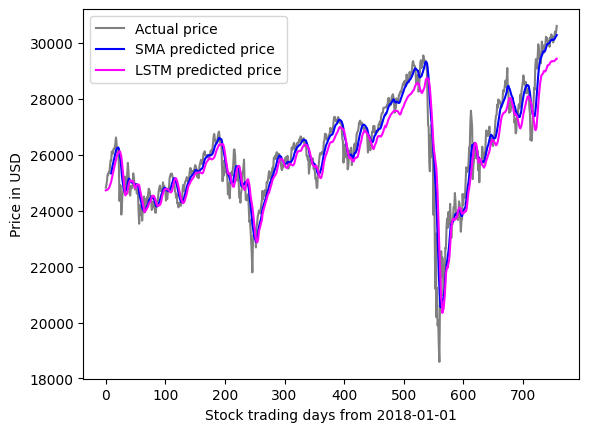

In [27]:
plt.plot(data2['act1'], label = 'Actual price', color = 'grey')
plt.plot(data2['SMA'], label = 'SMA predicted price', color = 'blue')
plt.plot(data2['pred1'], label = 'LSTM predicted price', color = 'magenta')





plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in USD')

plt.legend()
plt.show

In [28]:
math.sqrt(metrics.mean_squared_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna()))

586.5771074913899

In [29]:
metrics.mean_absolute_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna())

388.90446637182913

# Data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

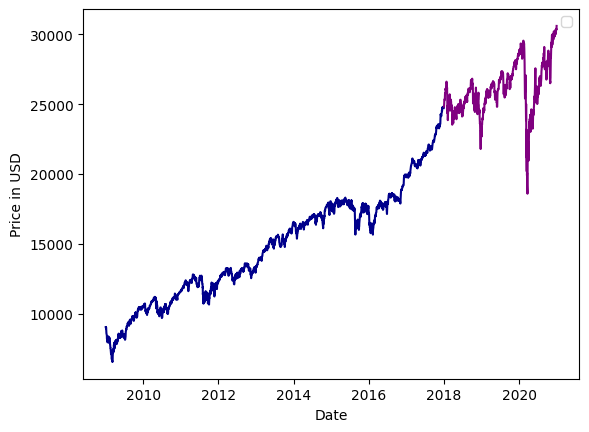

In [30]:
plt.plot(train_data['Date'],train_data['Close'], color ='darkblue')
plt.plot(test_data['Date'],test_data['Close'],color = 'purple')
plt.xlabel('Date')
plt.ylabel('Price in USD')

plt.legend()
plt.show


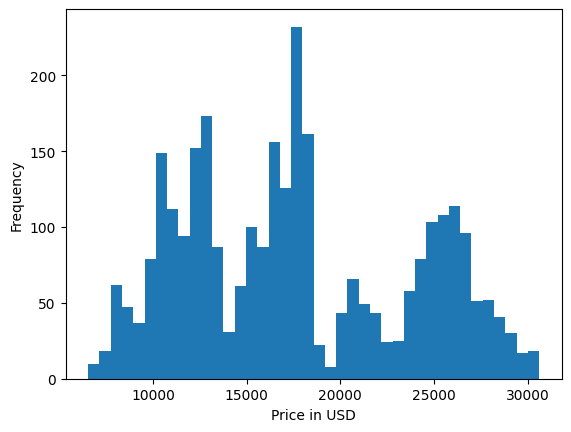

In [31]:
plt.hist(data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

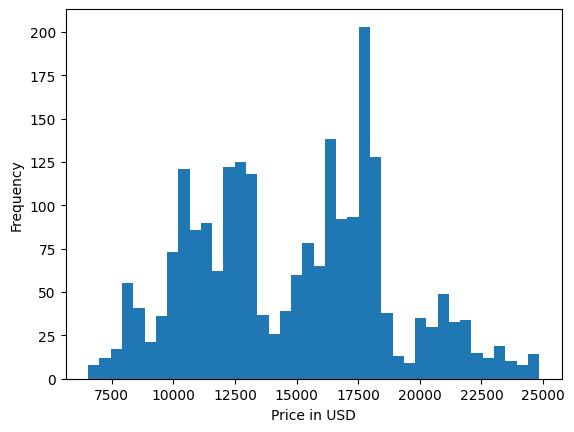

In [32]:
plt.hist(train_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

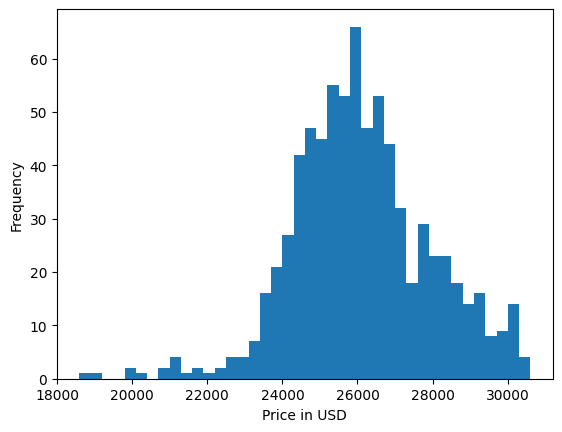

In [33]:
plt.hist(test_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [34]:
adfuller(data['Close'])

(-0.2374306644271012,
 0.933910414810336,
 27,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40354.406843980214)

In [35]:
adfuller(train_data['Close'])

(0.7775683223479853,
 0.9912653130447012,
 5,
 2259,
 {'1%': -3.433248072725654,
  '5%': -2.8628202931061955,
  '10%': -2.567451559747925},
 27858.556193600827)

In [36]:
adfuller(test_data['Close'])

(-2.4347580246079366,
 0.13216551805070903,
 9,
 746,
 {'1%': -3.439146171679794,
  '5%': -2.865422101274577,
  '10%': -2.568837245865348},
 10713.676404706486)

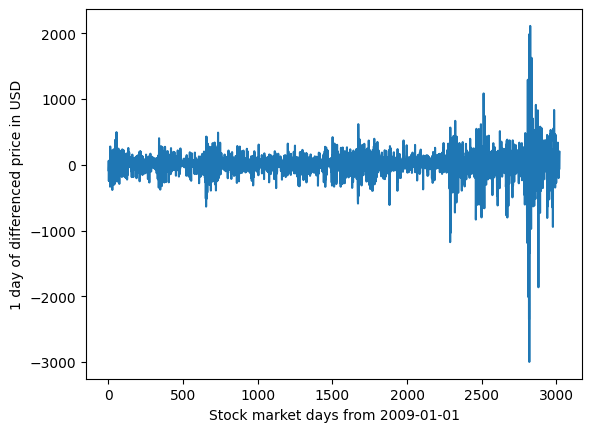

In [37]:
plt.plot(data['Close'].diff(periods=1).dropna())
plt.xlabel('Stock market days from 2009-01-01')
plt.ylabel('1 day of differenced price in USD')
plt.show()

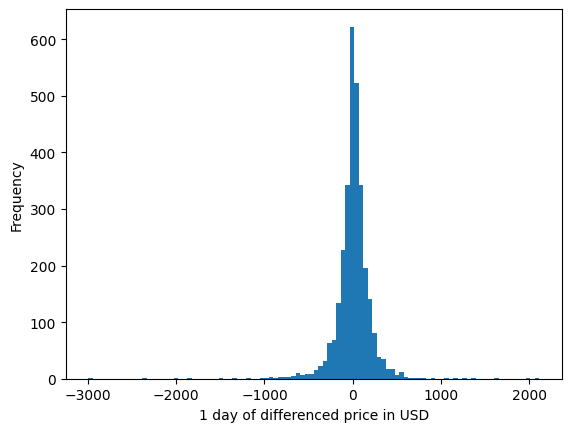

In [38]:
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 100)
plt.xlabel('1 day of differenced price in USD')
plt.ylabel('Frequency')
plt.show()

In [39]:
adfuller(data['Close'].dropna().diff(periods=1).dropna()) 

(-11.336769226111153,
 1.0788949870548927e-20,
 26,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40337.32991933587)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 1.700e+01,
        1.700e+01, 3.900e+01, 9.600e+01, 2.030e+02, 5.690e+02, 1.144e+03,
        5.380e+02, 2.210e+02, 7.400e+01, 3.500e+01, 1.800e+01, 4.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([-2997.09960938, -2894.89800781, -2792.69640625, -2690.49480469,
        -2588.29320313, -2486.09160156, -2383.89      , -2281.68839844,
        -2179.48679687, -2077.28519531, -1975.08359375, -1872.88199219,
        -1770.68039062, -1668.47878906, -1566.2771875 , -1464.07558594,
        -1361.87398437, -1259.67238281, -1157.47078125, -1055.26917969,
         -953.06

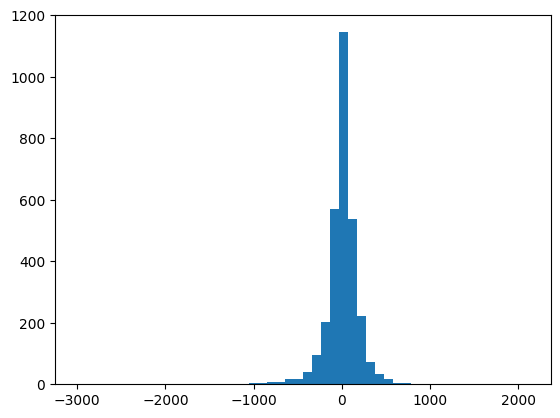

In [40]:
adfuller(scaled_data)
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 50)

In [ ]:
### EXAMPLE

#perform augmented Dickey-Fuller test
#adfuller(data)

#(-0.9753836234744063,
# 0.7621363564361013,
# 0,
# 12,
# {'1%': -4.137829282407408,
#  '5%': -3.1549724074074077,
#  '10%': -2.7144769444444443},
# 31.2466098872313)
#Here’s how to interpret the most important values in the output:

#Test statistic: -0.97538
#P-value: 0.7621
#Since the p-value is not less than .05, we fail to reject the null hypothesis.

#This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


## För att få bort non-stationarity kan vi differentiera
#df["series"].diff(periods=1)

